In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

import os
import optuna



In [ ]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

###############   Transforming Data #################
train_transform = transforms.Compose([
    
    transforms.ToTensor(),
#  transforms.Normalize((0.5,),(0.5,)),
])
test_transform = transforms.Compose([

    transforms.ToTensor(),
#  transforms.Normalize((0.5,),(0.5,)),
 ]
 )




train_dataset.transform = train_transform
test_dataset.transform = test_transform



train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

#### Dispalying ####

img, label= next(iter(train_dataloader))
print(f'Image Shape : {img.shape}')
print(f'Label Shape : {img.shape}')

print("----------Label Shape---------------")

img, label= next(iter(test_dataloader))
print(f'Image Shape : {img.shape}')
print(f'Label Shape : {img.shape}')





Image Shape : torch.Size([256, 1, 28, 28])
Label Shape : torch.Size([256, 1, 28, 28])
----------Label Shape---------------
Image Shape : torch.Size([10000, 1, 28, 28])
Label Shape : torch.Size([10000, 1, 28, 28])


# AutoEncoder  


In [ ]:
class Encoder(nn.Module):
  def __init__(self, encoded_space_dim , convh , linh):
    super().__init__()
    print("Encoder Initializing !")

    self.conv2d = nn.Sequential(
                  nn.Conv2d(in_channels=1, out_channels=convh, kernel_size=3, stride=2, padding=1),
                  nn.ReLU(),

                  nn.Conv2d(in_channels=convh, out_channels=2*convh , kernel_size=3, stride=2, padding=1),
                  nn.ReLU(),

                  nn.Conv2d(in_channels=2*convh, out_channels=4*convh, kernel_size=3, stride=2, padding=0),
                  nn.ReLU(),
                  
                  )
    self.flatten = nn.Flatten(start_dim =1 )
    self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=3*3*4*convh, out_features=linh),
            nn.ReLU(True),
            nn.Linear(in_features=linh, out_features=encoded_space_dim)
        )
    

  def forward(self, x ):
      x = self.conv2d(x)
      x = self.flatten(x)
      x = self.encoder_lin(x)

      return x


In [ ]:
class Decoder (nn.Module):
  def __init__(self,encoded_space_dim , convh , linh):

    super(). __init__()
    print("Decoder Initialized !")

    self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=linh),
            nn.ReLU(True),

            nn.Linear(in_features=linh, out_features=3*3*4*convh),
            nn.ReLU(True),
        )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(4*convh, 3, 3))
    
    self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4*convh, out_channels=2*convh, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=2*convh, out_channels=convh, kernel_size=3,  stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
 
            nn.ConvTranspose2d(in_channels=convh, out_channels=1, kernel_size=3,  stride=2, padding=1, output_padding=1)
        )
    

  def forward(self , x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [ ]:
convh = 16
linh = 64
encoded_space_dim = 16
lr=1e-3

encoder = Encoder(encoded_space_dim , convh , linh)
decoder = Decoder(encoded_space_dim , convh , linh)



img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('\n\nOriginal image shape:', img.shape)


img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Encoder Initializing !
Decoder Initialized !


Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 16])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device} \n')

# encoder.to(device)
# decoder.to(device)

Selected device: cuda 



In [ ]:
class TrainVal():
  def __init__(self, net ,device , loss, optim):
    self.encoder = net['encoder']
    self.decoder = net['decoder']

    self.device = device
    self.loss = loss
    self.optimizer = optim

  def train_step(self,dataloader):
    self.encoder.train()
    self.decoder.train()
    total_loss =0

    for image_batch, _ in dataloader: 

      image_batch = image_batch.to(self.device)
      encoded_data = self.encoder(image_batch)
      decoded_data = self.decoder(encoded_data)
      loss = self.loss(decoded_data, image_batch)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()
    return total_loss / len(dataloader)
      
  def validation_step(self , dataloader):

    valid_loss = 0
    self.encoder.eval()
    self.decoder.eval()

    with torch.no_grad(): 

      for image_batch, _ in dataloader:
        image_batch = image_batch.to(self.device)
        encoded_data = self.encoder(image_batch)
        decoded_data = self.decoder(encoded_data)
        loss = self.loss(decoded_data, image_batch)

        valid_loss += loss.item()
      return valid_loss / len(dataloader)


In [ ]:
loss_fn = torch.nn.MSELoss()

def train_model(parameters, device,epochs, loss_fn = loss_fn ):
  encoder = Encoder(parameters['encoded_space_dim']  , parameters['convh'] , parameters['linh']).to(device)
  decoder = Decoder(parameters['encoded_space_dim'] , parameters['convh'] , parameters['linh']).to(device)
  params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ]
  optim = torch.optim.Adam(params_to_optimize, lr=parameters['lr'], weight_decay=1e-5 )

  nets = {"encoder" : encoder , "decoder" : decoder}
  model = TrainVal(nets ,device , loss_fn, optim)

  train_loss_log = []
  val_loss_log = []

  best_loss=np.inf
  early_stopping = 5
  early_stopping_counter=0
  save_model_state=True

  for epoch in range(epochs):

    train_loss = model.train_step(train_dataloader)
    valid_loss = model.validation_step(test_dataloader)

    train_loss_log.append(train_loss)
    val_loss_log.append(valid_loss)

    print("-----------------------")
    print(f"##  Epoch : {epoch}  ##")
    print("-----------------------")

    print(f' Training Loss {train_loss}  Validation Loss {valid_loss}')


    if valid_loss < best_loss:
      best_loss = valid_loss
      early_stopping_counter = 0
    if save_model_state:
      torch.save(nets["encoder"].state_dict(), f'model_encoder.bin')
      torch.save(nets["decoder"].state_dict(), f'decoder_state.bin')
    else :
        early_stopping_counter+=1
    if early_stopping_counter>early_stopping:
        break


    if (epoch % 5) == 0:

      test_img = test_dataset[0][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          decoded_img  = decoder(encoder(test_img))

      print("reconstructed shape ",test_img.shape)
      print("reconstructed shape ",decoded_img.shape)

      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(test_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(decoded_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Decoded image (EPOCH %d)' % (epoch + 1))
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % parameters['encoded_space_dim'], exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (parameters['encoded_space_dim'], epoch + 1))
      plt.show()
      plt.close()
  print("\n---------------- Ploting Training and Validation Loss ----------------\n")
  print(train_loss_log[-1])
  print(val_loss_log[-1])

  # Plot losses of the best model
  plt.figure(figsize=(8,6))
  plt.semilogy(train_loss_log, label='Train loss')
  plt.semilogy(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


  return train_loss

Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.72259971740398  Validation Loss 0.6786004304885864
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


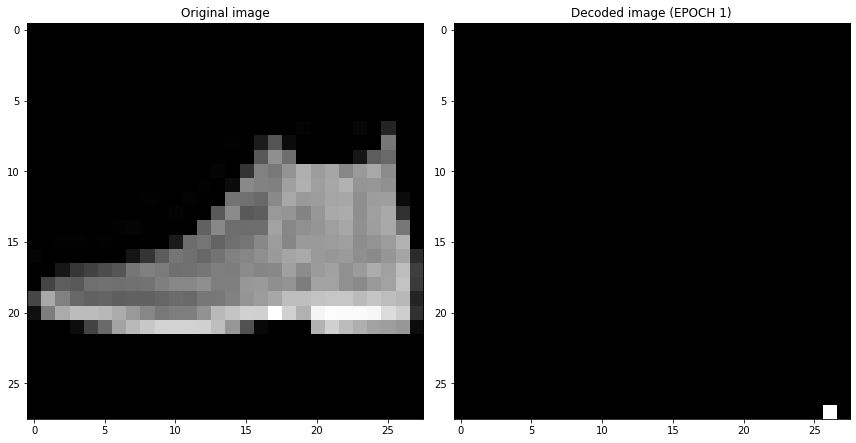

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.6816607520935384  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.6816243278219345  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.6816565432447068  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.681625941205532  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.6816297439818687  Validation Loss 0.6786004304885864
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


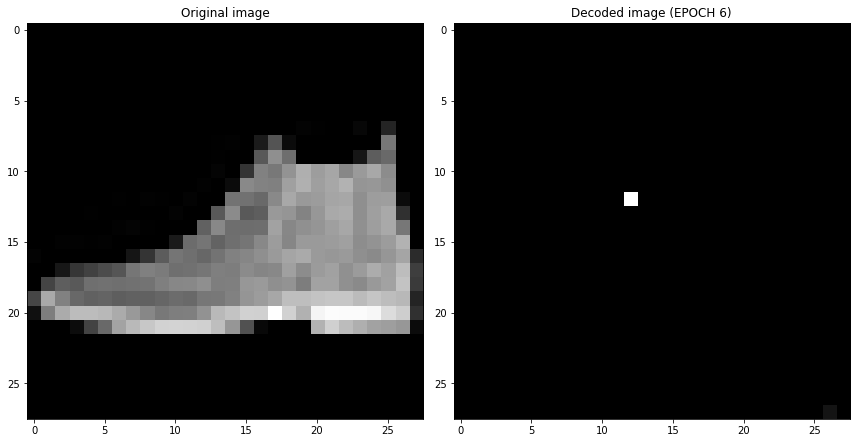

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.6815336382135432  Validation Loss 0.6785614490509033
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.6651680999613823  Validation Loss 0.6237327456474304
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.614253334796175  Validation Loss 0.6051203608512878
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.604887999879553  Validation Loss 0.6005939841270447
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.6014087654174642  Validation Loss 0.5978871583938599
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


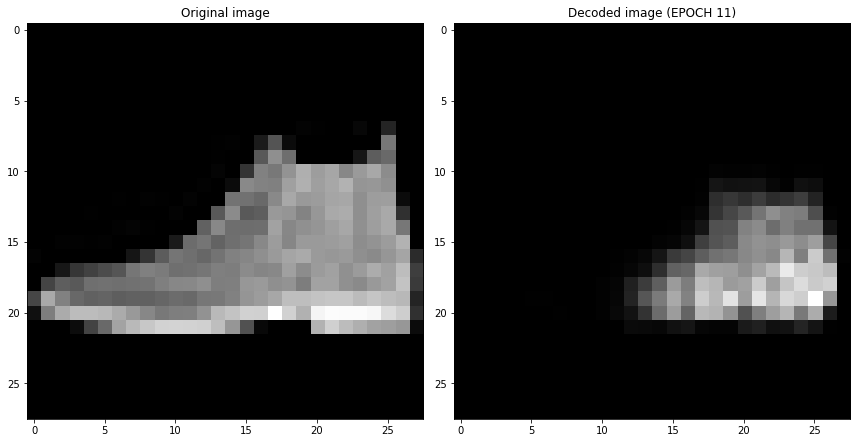

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.5992965642442094  Validation Loss 0.5965894460678101
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.5980537513469127  Validation Loss 0.5952542424201965
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.5968871294183934  Validation Loss 0.5944345593452454
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.5961312002324043  Validation Loss 0.5940049886703491
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.5955057943120916  Validation Loss 0.5929245948791504
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


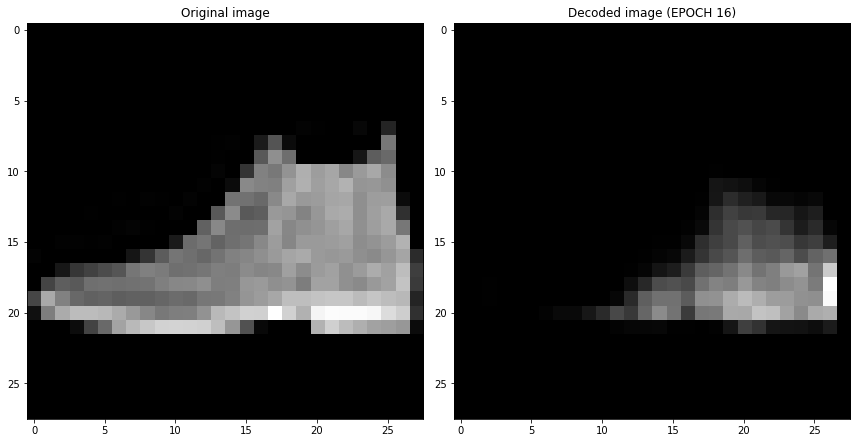

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.5951365881777825  Validation Loss 0.5926697850227356
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.5946743977830765  Validation Loss 0.5923215746879578
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.5943815753815022  Validation Loss 0.592045783996582
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.5942038366135131  Validation Loss 0.5918312668800354
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.5939424228160939  Validation Loss 0.5916413068771362
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


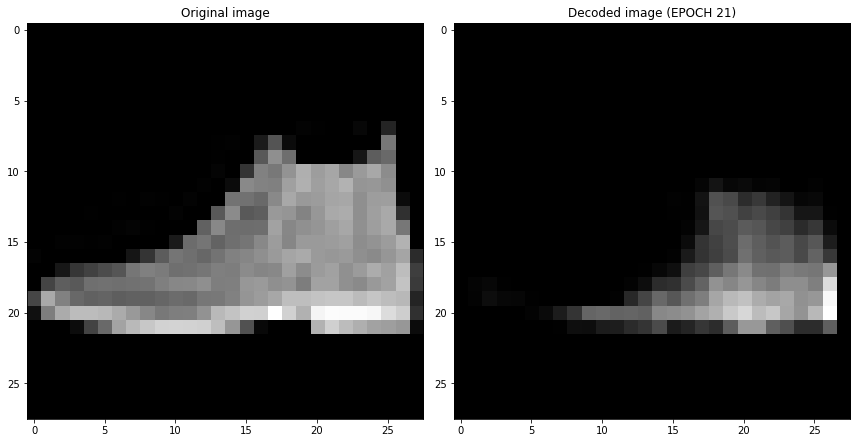

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.5937307865061658  Validation Loss 0.5916446447372437
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.5936007700067886  Validation Loss 0.5913246273994446
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.5934651326625905  Validation Loss 0.5910220742225647
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.5932180767363691  Validation Loss 0.5910012722015381
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.5930994723705535  Validation Loss 0.5908525586128235
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


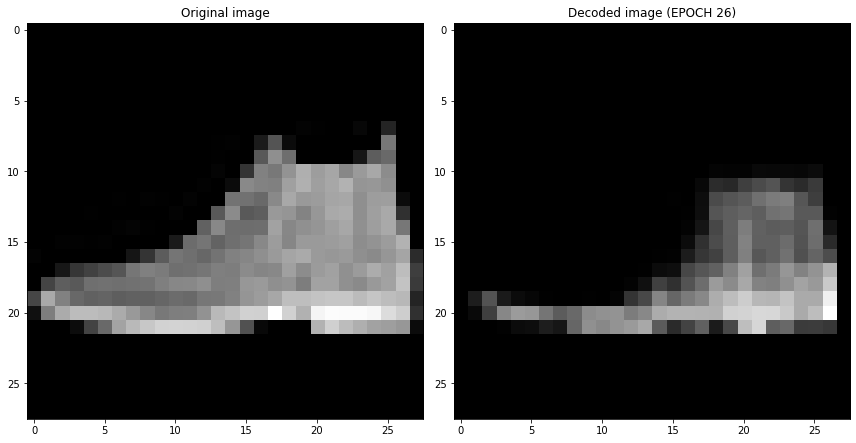

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.5930233757546608  Validation Loss 0.5909695029258728
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.5929284701956079  Validation Loss 0.5907052159309387
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.5927912826233722  Validation Loss 0.5904920101165771
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.5928168329786747  Validation Loss 0.5908553004264832

---------------- Ploting Training and Validation Loss ----------------

0.5928168329786747
0.5908553004264832


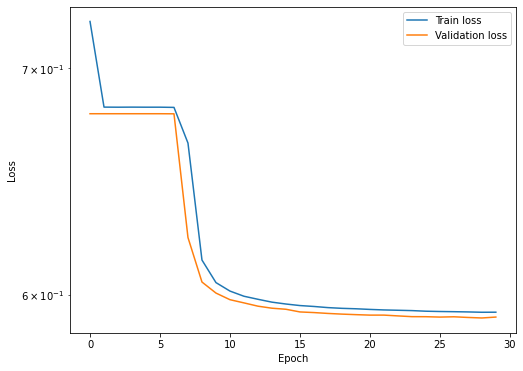

In [ ]:
parameters ={
      "convh": 16,
      "linh" : 64,
      "lr" : 0.0015,
      "encoded_space_dim": 8


  }

loss_fn = torch.nn.MSELoss()
epochs = 30


train_loss = train_model(parameters, device, epochs, loss_fn = loss_fn )

#Optuna

In [ ]:

def objective(trial):
  param ={
      "convh":trial.suggest_int("convh", 16, 32),
      "linh" : trial.suggest_int("linh", 64, 128),
      "lr" : trial.suggest_float("lr",1e-5, 1e-1 ,  log=True),
      "encoded_space_dim": trial.suggest_int("encoded_space_dim", 2, 12)


  }

  train_loss = train_model(parameters , device,epochs, loss_fn = loss_fn )
  return train_loss

[I 2022-09-14 00:01:13,897] A new study created in memory with name: no-name-ba23a28e-1a90-44e9-ac7c-278c75824880


Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.7209440905997093  Validation Loss 0.6786004304885864
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


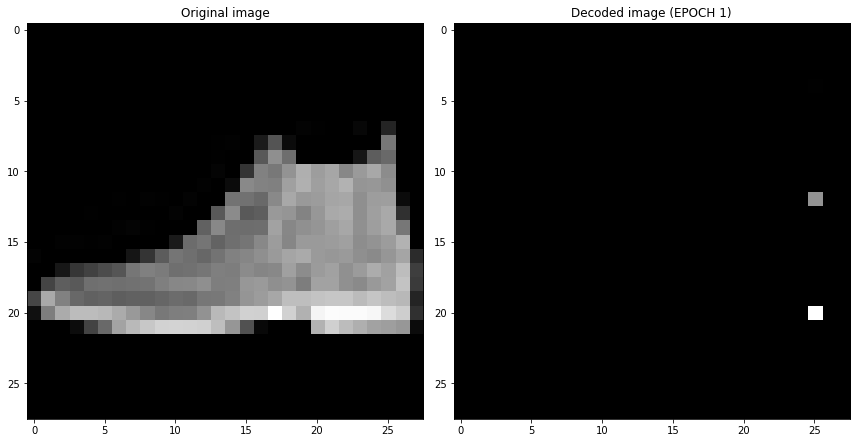

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.6816179828440889  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.6816940680463264  Validation Loss 0.6786004900932312
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.6816742016914042  Validation Loss 0.6786018013954163
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.681538572970857  Validation Loss 0.6782253384590149
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.637160986027819  Validation Loss 0.6113529205322266
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


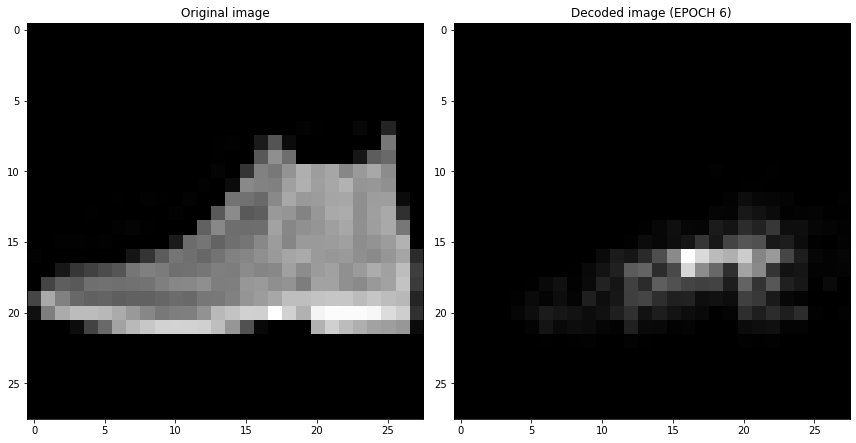

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.6084062553466635  Validation Loss 0.6033308506011963
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.6038980722427368  Validation Loss 0.6002482175827026
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.6015966506714516  Validation Loss 0.5985378623008728
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.600336272412158  Validation Loss 0.5976161956787109
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.59932285268256  Validation Loss 0.5965415835380554
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


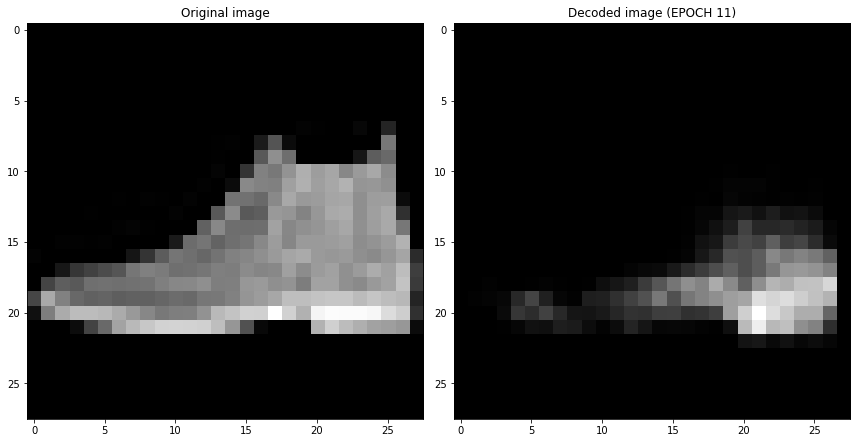

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.5982582848122779  Validation Loss 0.5953887701034546
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.5974709006066018  Validation Loss 0.5948587656021118
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.5969194627822714  Validation Loss 0.5945788025856018
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.5963770080120006  Validation Loss 0.593953549861908
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.5960476814432347  Validation Loss 0.5939315557479858
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


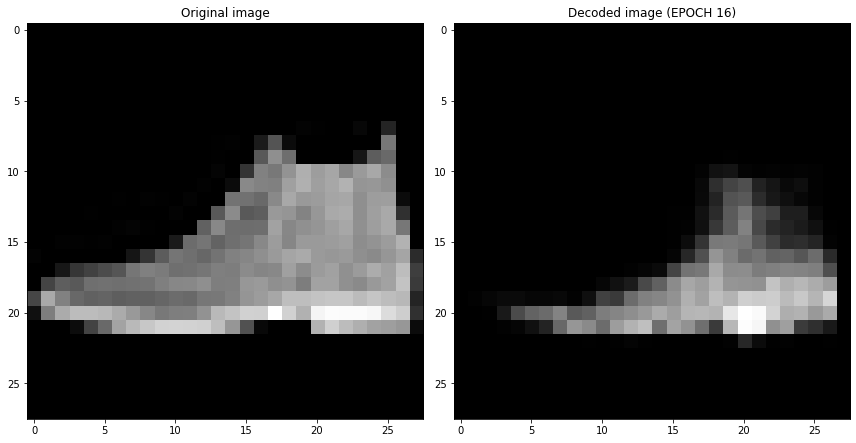

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.5956507140017571  Validation Loss 0.593375563621521
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.5953723722315849  Validation Loss 0.5930086374282837
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.5950425038946435  Validation Loss 0.5928460359573364
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.5947718407245393  Validation Loss 0.5926010012626648
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.5944289240431279  Validation Loss 0.5920756459236145
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


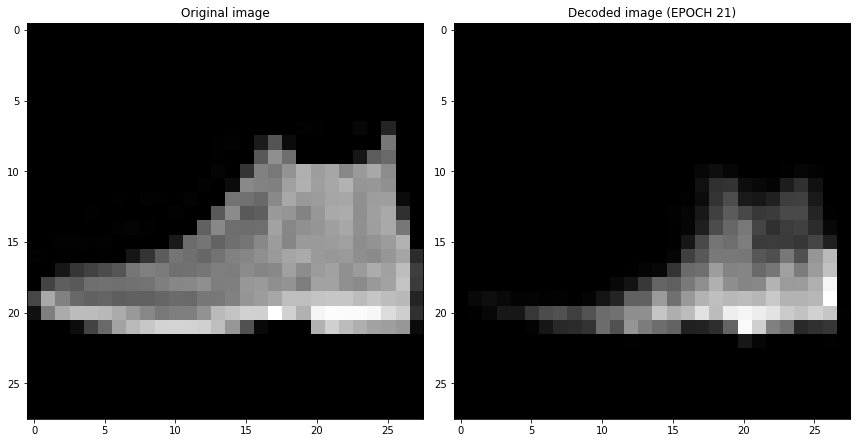

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.5941915408093879  Validation Loss 0.5918158888816833
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.5938893120339577  Validation Loss 0.5915142297744751
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.593579571551465  Validation Loss 0.5913876891136169
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.5933705362867802  Validation Loss 0.5912448763847351
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.5930733657897787  Validation Loss 0.5910913944244385
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


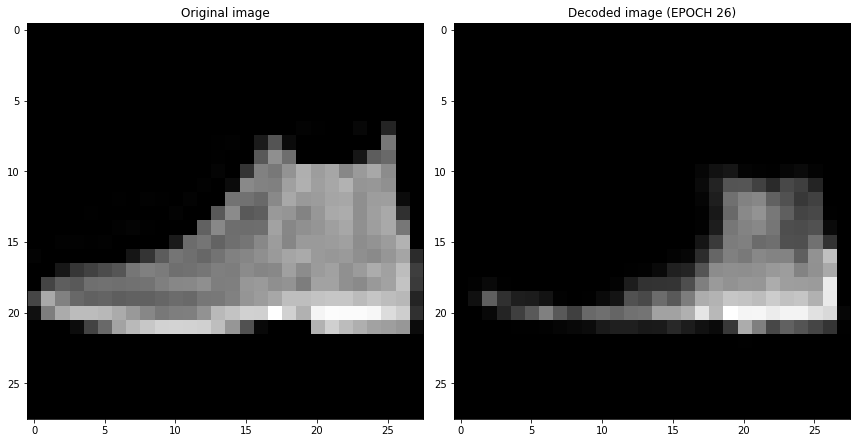

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.5929646773541227  Validation Loss 0.590782880783081
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.5926851660647291  Validation Loss 0.5906096696853638
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.5925375773551617  Validation Loss 0.5904899835586548
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.5924536159698  Validation Loss 0.5903031229972839

---------------- Ploting Training and Validation Loss ----------------

0.5924536159698
0.5903031229972839


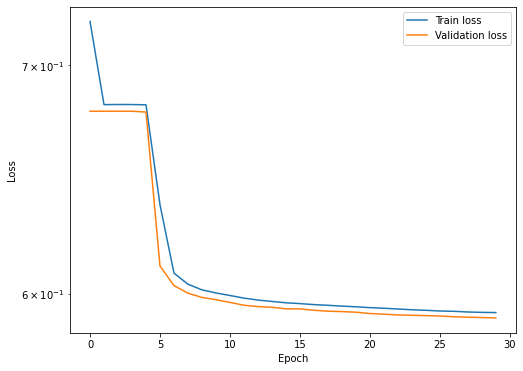

[I 2022-09-14 00:07:41,880] Trial 0 finished with value: 0.5924536159698 and parameters: {'convh': 25, 'linh': 97, 'lr': 0.0003579099022507033, 'encoded_space_dim': 8}. Best is trial 0 with value: 0.5924536159698.


Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.7272471263053569  Validation Loss 0.6786004304885864
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


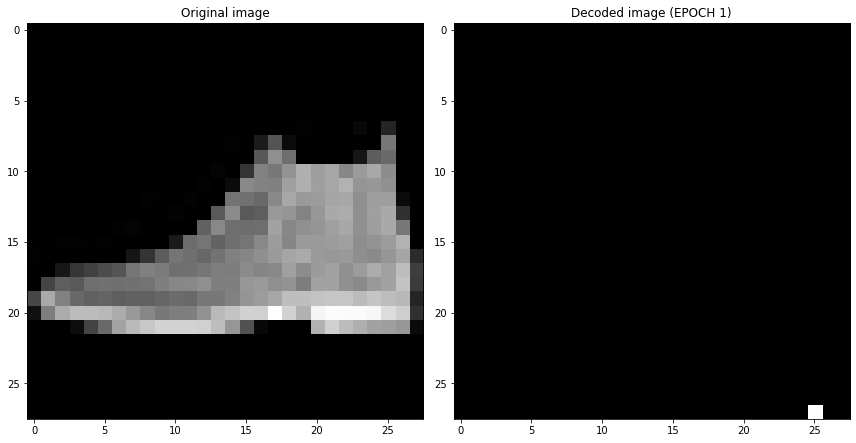

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.6816301594389246  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.6816090076527697  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.6816393446415029  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.6816327861014833  Validation Loss 0.6786004304885864
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.6815914524362442  Validation Loss 0.6786004304885864
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


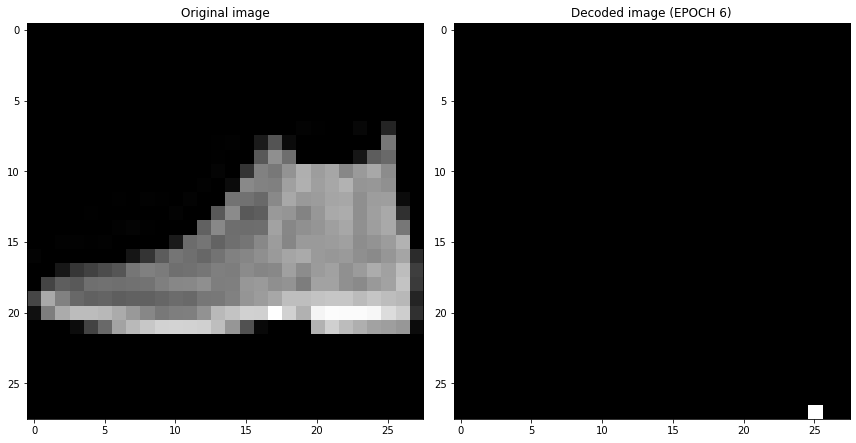

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.6815366618176724  Validation Loss 0.6786004900932312
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.6816650707670983  Validation Loss 0.6786006093025208
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.6816037431676337  Validation Loss 0.6785867214202881
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.6599461355107896  Validation Loss 0.6257585883140564
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.6159319372887307  Validation Loss 0.6052621006965637
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


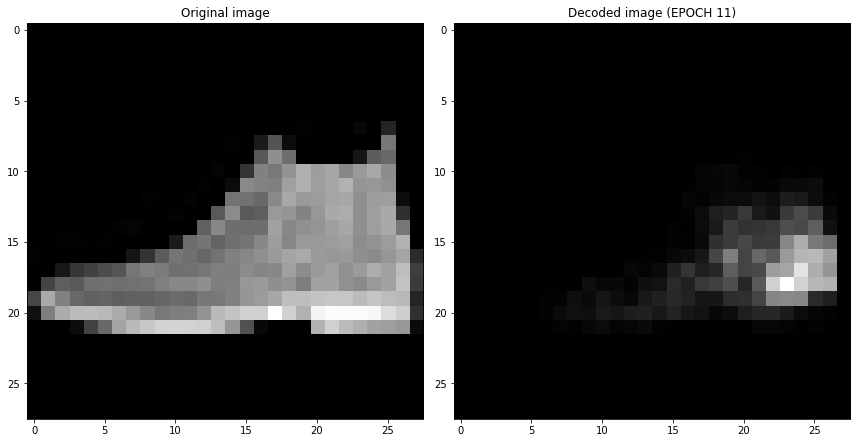

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.6059833064992377  Validation Loss 0.6024020314216614
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.6036287196139072  Validation Loss 0.6005333662033081
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.6016154667164417  Validation Loss 0.5986625552177429
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.6003170482655789  Validation Loss 0.5977693796157837
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.5994596029849762  Validation Loss 0.5969206690788269
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


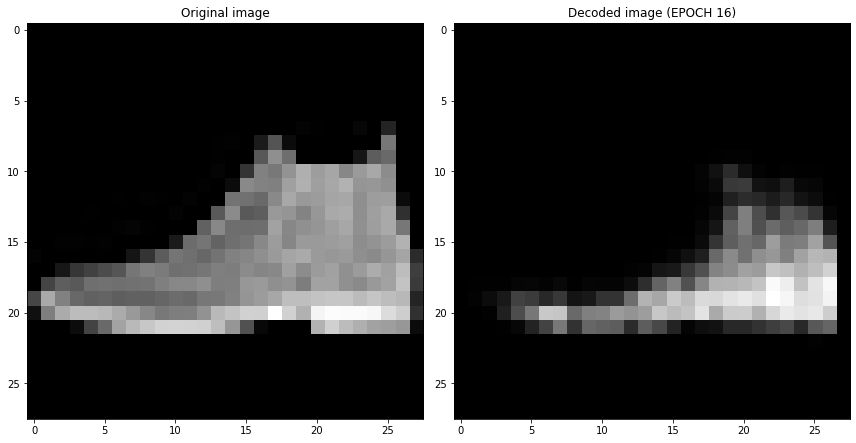

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.598573801872578  Validation Loss 0.5957722663879395
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.597516457831606  Validation Loss 0.595064640045166
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.5969032787262125  Validation Loss 0.5943622589111328
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.5964190658102644  Validation Loss 0.5939096212387085
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.5959166628249148  Validation Loss 0.5935800075531006
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


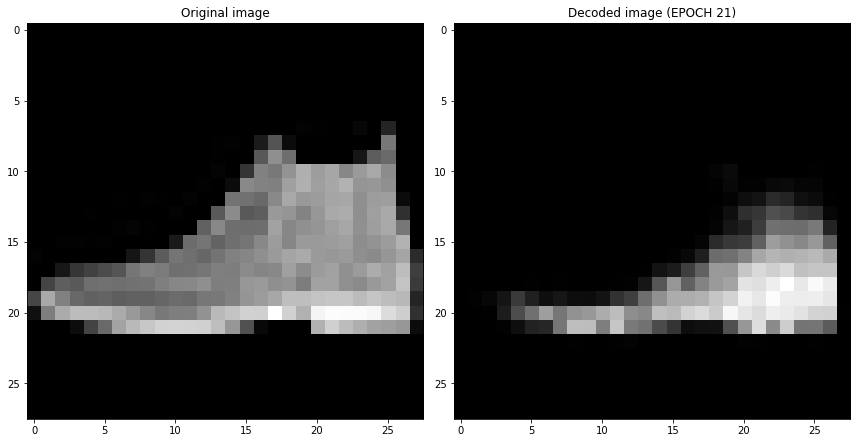

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.5955149582091798  Validation Loss 0.5931754112243652
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.595049795952249  Validation Loss 0.5926179885864258
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.5947647376263395  Validation Loss 0.592361330986023
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.5944485103830378  Validation Loss 0.5922938585281372
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.5943063794298374  Validation Loss 0.5919197797775269
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


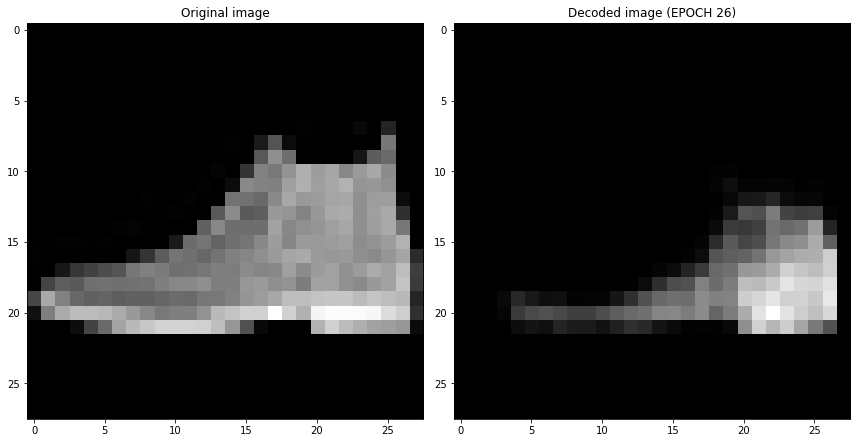

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.5940411491596952  Validation Loss 0.5917143821716309
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.5938086098812996  Validation Loss 0.5919488668441772
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.5936932700745603  Validation Loss 0.5915493369102478
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.5935293753096398  Validation Loss 0.5914424061775208

---------------- Ploting Training and Validation Loss ----------------

0.5935293753096398
0.5914424061775208


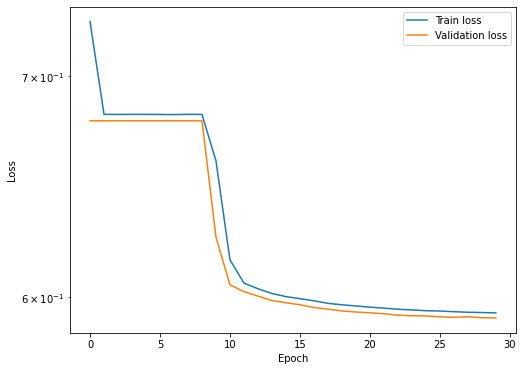

[I 2022-09-14 00:14:14,254] Trial 1 finished with value: 0.5935293753096398 and parameters: {'convh': 19, 'linh': 89, 'lr': 0.06468831250567707, 'encoded_space_dim': 7}. Best is trial 0 with value: 0.5924536159698.


Number of finished trials: 2
Best trial:
Value of trial:  0.5924536159698
Best Parameter Found: 
    convh: 25
    linh: 97
    lr: 0.0003579099022507033
    encoded_space_dim: 8


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, timeout=600)


print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("Value of trial: ", trial.value)

print("Best Parameter Found: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#Best Model

{'convh': 25, 'linh': 97, 'lr': 0.0003579099022507033, 'encoded_space_dim': 8}
Encoder Initializing !
Decoder Initialized !
-----------------------
##  Epoch : 0  ##
-----------------------
 Training Loss 0.7794081132462685  Validation Loss 0.6786004900932312
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


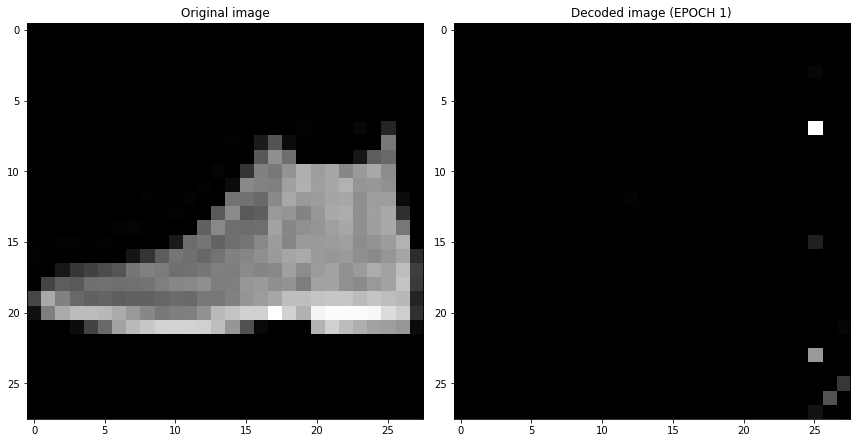

-----------------------
##  Epoch : 1  ##
-----------------------
 Training Loss 0.6816270683674102  Validation Loss 0.6786004900932312
-----------------------
##  Epoch : 2  ##
-----------------------
 Training Loss 0.6815963001961404  Validation Loss 0.6786004900932312
-----------------------
##  Epoch : 3  ##
-----------------------
 Training Loss 0.6816653117220453  Validation Loss 0.6786004900932312
-----------------------
##  Epoch : 4  ##
-----------------------
 Training Loss 0.681703058202216  Validation Loss 0.6786006093025208
-----------------------
##  Epoch : 5  ##
-----------------------
 Training Loss 0.6816478985421202  Validation Loss 0.6786006093025208
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


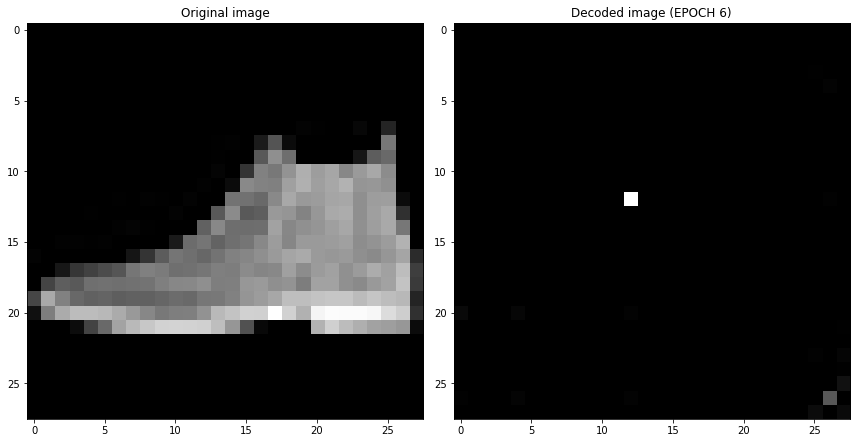

-----------------------
##  Epoch : 6  ##
-----------------------
 Training Loss 0.681601602980431  Validation Loss 0.6786006689071655
-----------------------
##  Epoch : 7  ##
-----------------------
 Training Loss 0.6816478782511772  Validation Loss 0.6785995960235596
-----------------------
##  Epoch : 8  ##
-----------------------
 Training Loss 0.6815684787770535  Validation Loss 0.6784831285476685
-----------------------
##  Epoch : 9  ##
-----------------------
 Training Loss 0.6682580082974535  Validation Loss 0.636371910572052
-----------------------
##  Epoch : 10  ##
-----------------------
 Training Loss 0.6286418166566402  Validation Loss 0.6150771379470825
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


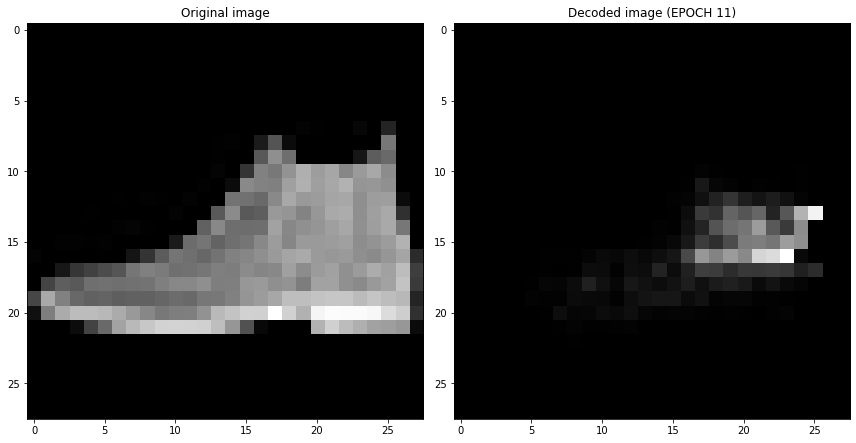

-----------------------
##  Epoch : 11  ##
-----------------------
 Training Loss 0.612712175288099  Validation Loss 0.6072589159011841
-----------------------
##  Epoch : 12  ##
-----------------------
 Training Loss 0.6079531469243638  Validation Loss 0.6041728258132935
-----------------------
##  Epoch : 13  ##
-----------------------
 Training Loss 0.6055414466147727  Validation Loss 0.6020172238349915
-----------------------
##  Epoch : 14  ##
-----------------------
 Training Loss 0.6036383644063422  Validation Loss 0.6004685163497925
-----------------------
##  Epoch : 15  ##
-----------------------
 Training Loss 0.6020116981039656  Validation Loss 0.5990641713142395
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


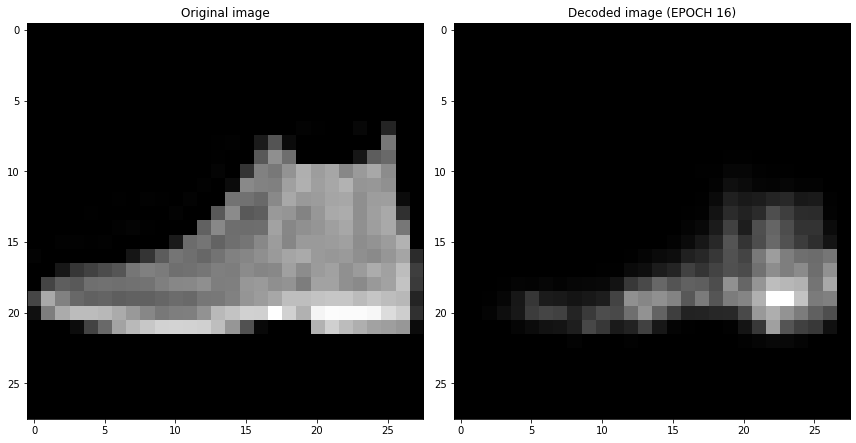

-----------------------
##  Epoch : 16  ##
-----------------------
 Training Loss 0.6007442522556223  Validation Loss 0.5979931950569153
-----------------------
##  Epoch : 17  ##
-----------------------
 Training Loss 0.5998718122218517  Validation Loss 0.5974442362785339
-----------------------
##  Epoch : 18  ##
-----------------------
 Training Loss 0.5991909732209876  Validation Loss 0.5966036319732666
-----------------------
##  Epoch : 19  ##
-----------------------
 Training Loss 0.5985337490731097  Validation Loss 0.5959387421607971
-----------------------
##  Epoch : 20  ##
-----------------------
 Training Loss 0.597981059551239  Validation Loss 0.5953834056854248
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


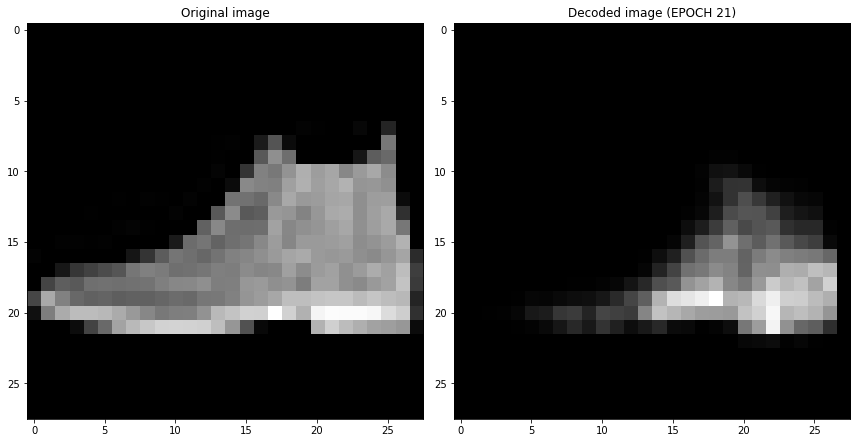

-----------------------
##  Epoch : 21  ##
-----------------------
 Training Loss 0.5975588288713009  Validation Loss 0.5950581431388855
-----------------------
##  Epoch : 22  ##
-----------------------
 Training Loss 0.5971656266679155  Validation Loss 0.5946468114852905
-----------------------
##  Epoch : 23  ##
-----------------------
 Training Loss 0.5968583304831322  Validation Loss 0.5943410396575928
-----------------------
##  Epoch : 24  ##
-----------------------
 Training Loss 0.5965285057717181  Validation Loss 0.5941358804702759
-----------------------
##  Epoch : 25  ##
-----------------------
 Training Loss 0.5962017962273131  Validation Loss 0.5939379334449768
reconstructed shape  torch.Size([1, 1, 28, 28])
reconstructed shape  torch.Size([1, 1, 28, 28])


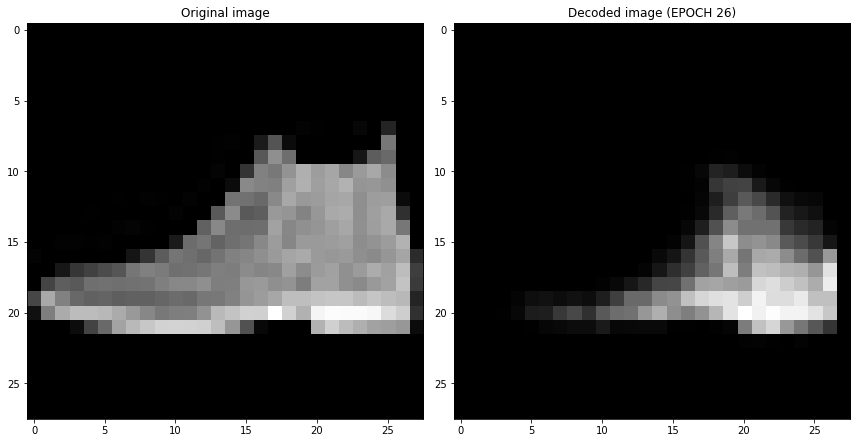

-----------------------
##  Epoch : 26  ##
-----------------------
 Training Loss 0.5959748854028418  Validation Loss 0.593784511089325
-----------------------
##  Epoch : 27  ##
-----------------------
 Training Loss 0.595763505012431  Validation Loss 0.5933296084403992
-----------------------
##  Epoch : 28  ##
-----------------------
 Training Loss 0.5955646238428481  Validation Loss 0.5930877327919006
-----------------------
##  Epoch : 29  ##
-----------------------
 Training Loss 0.5952525925129017  Validation Loss 0.5928778052330017

---------------- Ploting Training and Validation Loss ----------------

0.5952525925129017
0.5928778052330017


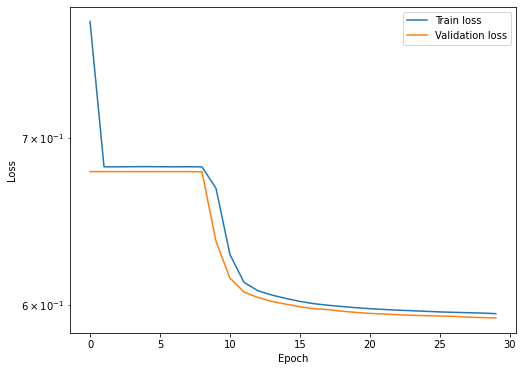

In [ ]:
print(trial.params)
parameters = trial.params

train_loss = train_model(parameters, device, epochs, loss_fn = loss_fn )



#Classification

In [ ]:

from sklearn.model_selection import train_test_split
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split,)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets['train'],datasets['val']
train_set, val_set = train_val_dataset(train_dataset,0.2)


train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(val_set), shuffle=False)

In [ ]:
convh = parameters['convh']
linh = parameters['linh']
lr = parameters['lr']
encoded_space_dim = parameters['encoded_space_dim']
print(encoded_space_dim)
encoder = Encoder(encoded_space_dim , convh , linh)
encoder.load_state_dict(torch.load(f'model_encoder.bin'))
print(encoder)



8
Encoder Initializing !
Encoder(
  (conv2d): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(25, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(50, 100, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=900, out_features=97, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=97, out_features=8, bias=True)
  )
)


In [ ]:
encoder_classify = nn.Sequential(
    encoder,
    # nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(encoded_space_dim , 10)
)
print("------------ Classifier ( Encoder ) -------------")
model = encoder_classify.to(device)
print(model)

------------ Classifier ( Encoder ) -------------
Sequential(
  (0): Encoder(
    (conv2d): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(25, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(50, 100, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=900, out_features=97, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=97, out_features=8, bias=True)
    )
  )
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=8, out_features=10, bias=True)
)


In [ ]:
class classifier():
  def __init__(self, encoder ,device , loss, optim , scheduler):
    self.encoder = encoder
    self.scheduler = scheduler

    self.device = device
    self.loss = loss
    self.optimizer = optim

  def train_step(self,dataloader):
    self.encoder.train()
    total_loss =0

    for image_batch, labels in dataloader: 

      image_batch = image_batch.to(self.device)
      labels = labels.to(self.device)
      encoded_data = self.encoder(image_batch)

      loss = self.loss(encoded_data, labels)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()
    return total_loss / len(dataloader)
      
  def validation_step(self , dataloader):

    valid_loss = 0
    self.encoder.eval()

    with torch.no_grad(): 

      for image_batch, labels in dataloader:
        image_batch = image_batch.to(self.device)
        labels = labels.to(self.device)

        encoded_data = self.encoder(image_batch)
        loss = self.loss(encoded_data, labels)

        valid_loss += loss.item()

        if self.scheduler :
          self.scheduler.step(valid_loss/len(dataloader))
      return valid_loss / len(dataloader)

In [ ]:
epochs=30

lr= 1e-4

optimizer = torch.optim.Adam(encoder_classify.parameters(), lr=lr, weight_decay=1e-5 )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.2, threshold=1e-5,verbose=True)
loss = nn.CrossEntropyLoss()

classifier=classifier(model, device , loss, optimizer ,scheduler)

train_loss_log = []
val_loss_log = []

best_loss=np.inf
early_stopping = 5
early_stopping_counter=0
save_model = True
for epoch_num in range(20):
  print('-------- Training -------- ')
  print(f'# Epoch {epoch_num}')
  print('-------- Training --------')
  train_loss=classifier.train_step(train_dataloader)
  train_loss_log.append(train_loss)
  val_loss=classifier.validation_step(valid_dataloader)
  val_loss_log.append(val_loss)
  print(f" EPOCH {epoch_num}, TRAIN LOSS {train_loss}, VAL LOSS {val_loss}")
  if val_loss < best_loss :
    best_loss=val_loss
    early_stopping_counter=0
    if save_model:
      torch.save(model.state_dict(), f'model_classifier.bin')
  else :
    early_stopping_counter+=1
    if early_stopping_counter>early_stopping:
      break


-------- Training -------- 
# Epoch 0
-------- Training --------
 EPOCH 0, TRAIN LOSS 10.91963687348873, VAL LOSS 2.0800817012786865
-------- Training -------- 
# Epoch 1
-------- Training --------
 EPOCH 1, TRAIN LOSS 1.8827443858410449, VAL LOSS 1.2464215755462646
-------- Training -------- 
# Epoch 2
-------- Training --------
 EPOCH 2, TRAIN LOSS 1.3869616998002885, VAL LOSS 1.0491763353347778
-------- Training -------- 
# Epoch 3
-------- Training --------
 EPOCH 3, TRAIN LOSS 1.231118103291126, VAL LOSS 0.9676020741462708
-------- Training -------- 
# Epoch 4
-------- Training --------
 EPOCH 4, TRAIN LOSS 1.1445475848431284, VAL LOSS 0.8895376920700073
-------- Training -------- 
# Epoch 5
-------- Training --------
 EPOCH 5, TRAIN LOSS 1.077436495334544, VAL LOSS 0.8269941210746765
-------- Training -------- 
# Epoch 6
-------- Training --------
 EPOCH 6, TRAIN LOSS 1.0223822764893795, VAL LOSS 0.7963618040084839
-------- Training -------- 
# Epoch 7
-------- Training --------


In [ ]:

def testing( model ,loss, test_loader):

  model.eval()  #set evaluation mode

  corrects  = 0.
  totals    = 0.
  test_loss = 0.

  with torch.no_grad():
      for s_batch in test_dataloader:
          
          x_batch = s_batch[0].to(device)      
          label_b = s_batch[1].to(device)       #import labels, move to device 
          
          outputs = model(x_batch)
          
          test_loss += loss(outputs, label_b).item()
          
          _, predicted = torch.max(outputs.data, 1)
          totals += label_b.size(0)
          corrects += (predicted == label_b).sum().item()
      
      accuracy = (corrects / totals) * 100
      avg_test_loss = test_loss / totals
      
      print("Loss on Test Dataset:",avg_test_loss, "\n Accuracy:",accuracy)
          
  return avg_test_loss, accuracy , label_b ,outputs 


avg_test_loss, accuracy , label_b ,outputs = testing( model ,loss, test_dataloader)

Loss on Test Dataset: 5.341052412986755e-05 
 Accuracy: 81.89


In [ ]:
y_test=label_b.detach().cpu().squeeze().numpy()
y_pred=outputs.detach().cpu()
preds=[]
for pred in y_pred:
  preds.append(pred.argmax().item())
y_pred=np.array(preds)
print(y_test.shape,y_pred.shape)

(10000,) (10000,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

------ Result of Confusion Matrix -------

F1: 0.819
Recall: 0.819
Precision: 0.819


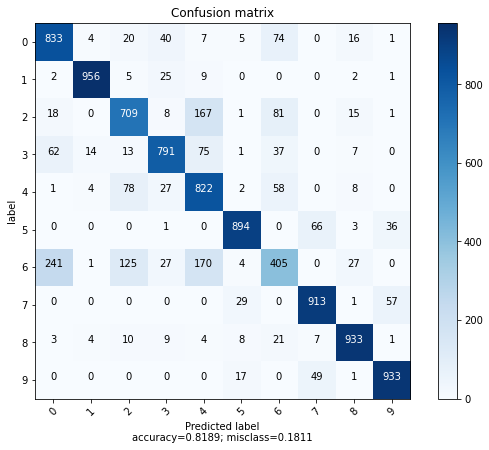

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



f1=f1_score(y_test, y_pred, average='micro')
prec=precision_score(y_test, y_pred, average='micro')
rec=recall_score(y_test, y_pred, average='micro')
print("------ Result of Confusion Matrix -------\n")
print("F1:",round(f1,3))
print("Recall:",round(rec,3))
print("Precision:",round(prec,3))

confusion_matrix = confusion_matrix(y_test, y_pred)
lab=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(confusion_matrix,lab, normalize=False)

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:09<00:00, 1018.08it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,label
0,-1.163541,-3.520506,-1.308010,0.511723,-2.901758,5.086263,5.098396,8.739604,9
1,3.571510,3.564428,0.062317,2.592374,-5.911665,-5.697509,1.643028,-0.681197,2
2,-1.872367,8.748462,6.398681,19.250448,10.080919,10.332475,-16.442060,6.101830,1
3,2.294627,6.376927,8.201312,12.306688,9.198073,9.745703,-20.227844,0.904354,1
4,1.330809,1.933521,-2.988004,-5.603104,-3.175378,-4.991033,-1.168152,2.461049,6
...,...,...,...,...,...,...,...,...,...
9995,-0.772621,-4.371160,-3.927423,-5.025306,-3.338929,9.050155,-1.913263,12.624166,9
9996,1.514480,2.398580,6.042001,4.628315,5.778633,3.772839,-10.116802,0.619937,1
9997,-4.215851,-3.130878,2.190834,0.212946,7.498736,-4.979974,1.730281,-4.046638,8
9998,-0.633404,1.351147,6.978354,5.613086,6.466650,6.972780,-14.051738,1.606845,1


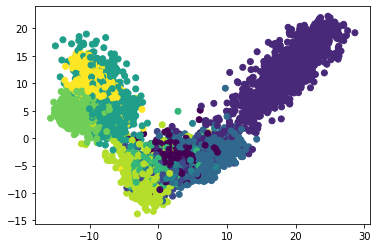

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA


plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


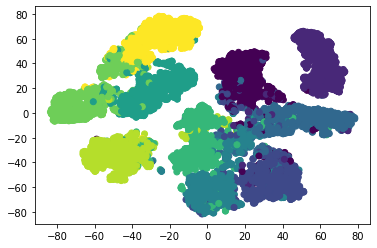

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca')
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

In [ ]:
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0][0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img.unsqueeze(0))
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append(encoded_img)
    labels.append(str(label))

100%|██████████| 10000/10000 [00:09<00:00, 1012.72it/s]


In [ ]:
convh = parameters['convh']
linh = parameters['linh']
lr = parameters['lr']
encoded_space_dim = parameters['encoded_space_dim']


encoder = Encoder(encoded_space_dim , convh , linh).to(device)
decoder = Decoder(encoded_space_dim , convh , linh).to(device)

Encoder Initializing !
Decoder Initialized !


In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
re_tsne = tsne.fit_transform(encoded_samples)


import plotly.express as px
px.scatter(x=re_tsne[:,0], y=re_tsne[:,1], color=labels, opacity=0.8)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


#Denoiser AutoEncoder

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting Noisydataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to Noisydataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting Noisydataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Noisydataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting Noisydataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Noisydataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting Noisydataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Noisydataset/FashionMNIST/raw

------------- Training Dataset -------------
 input: torch.Size([256, 1, 28, 28])
 input: torch.Size([256, 1, 28, 28])
 Label: torch.Size([256])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



------------- Test dataset -------------
input: torch.Size([256, 1, 28, 28])
input: torch.Size([256, 1, 28, 28])
 Label: torch.Size([256])


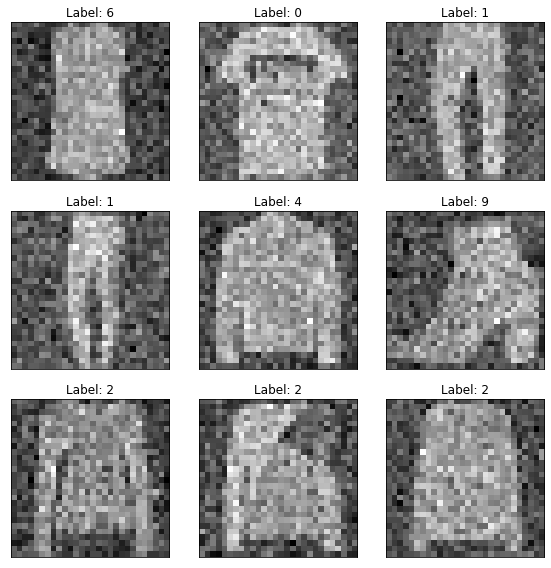

In [ ]:
class Noise(object):
  def __init__(self, sigma):
      self.sigma=sigma

  def __call__(self, image):
    noise=np.random.normal(loc=0.,scale=self.sigma,size=image.shape).astype(np.float)
    image_noise=image+torch.tensor(noise)
    image_noise=image_noise.type(torch.float32)
    return {'image': image, 'noise': image_noise}



sigma=0.5
train_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,)),
                                    Noise(sigma)
                                    ])
test_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,)),
                                    Noise(sigma)
                                    ])

data_dir = 'Noisydataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)



train_dataset.transform=train_transform
test_dataset.transform=test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"------------- Training Dataset -------------")
print(f" input: {batch_data['image'].shape}")
print(f" input: {batch_data['noise'].shape}")
print(f" Label: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"------------- Test dataset -------------")
print(f"input: {batch_data['image'].shape}")
print(f"input: {batch_data['noise'].shape}")
print(f" Label: {batch_labels.shape}")



fig, axs = plt.subplots(3, 3, figsize=(8,8))
for ax in axs.flatten():
    data, label = random.choice(train_dataset)
    img=data['noise'].squeeze(0)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
class denoise_engine:
  def __init__(self,model,optimizer,loss_fn,device):
    self.model=model
    self.optimizer=optimizer
    self.loss_fn=loss_fn
    self.device=device
  
  def train(self,dataloader):
    final_loss=0
    self.model["encoder"].train()
    self.model["decoder"].train()
    for sample_batched in dataloader:
      self.optimizer.zero_grad()
      images=sample_batched[0]['image'].to(self.device)
      noisy_images=sample_batched[0]['noise'].to(self.device)
      codes=self.model["encoder"](noisy_images)
      outputs=self.model["decoder"](codes)
      loss= self.loss_fn(outputs,images)
      loss.backward()
      self.optimizer.step()
      final_loss+=loss.item()
    return final_loss/len(dataloader)
  def evaluate(self,dataloader):
    final_loss=0
    conc_out=[]
    conc_label=[]
    self.model['encoder'].eval()
    self.model['decoder'].eval()
    for sample_batched in dataloader:
      self.optimizer.zero_grad()
      images=sample_batched[0]['image'].to(self.device)
      noisy_images=sample_batched[0]['noise'].to(self.device)
      codes=self.model["encoder"](noisy_images)
      outputs=self.model["decoder"](codes)
      loss= self.loss_fn(outputs,images)
      final_loss+=loss.item()
    return final_loss/len(dataloader)

Encoder Initializing !
Decoder Initialized !
----------- Training --------------
# Epoch 0
----------- Training --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



EPOCH 0, TRAIN LOSS 0.7689535501155448, VAL LOSS 0.6797093629837037
reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


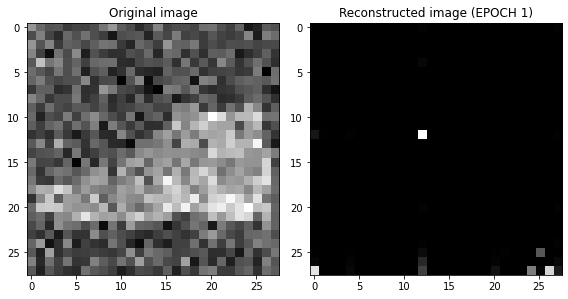

----------- Training --------------
# Epoch 1
----------- Training --------------
EPOCH 1, TRAIN LOSS 0.6816423740792782, VAL LOSS 0.6796257138252259
----------- Training --------------
# Epoch 2
----------- Training --------------
EPOCH 2, TRAIN LOSS 0.6719297332966582, VAL LOSS 0.6430356681346894
----------- Training --------------
# Epoch 3
----------- Training --------------
EPOCH 3, TRAIN LOSS 0.6344184325096455, VAL LOSS 0.6253951758146286
----------- Training --------------
# Epoch 4
----------- Training --------------
EPOCH 4, TRAIN LOSS 0.6197447561203165, VAL LOSS 0.6147874310612679
----------- Training --------------
# Epoch 5
----------- Training --------------
EPOCH 5, TRAIN LOSS 0.6138235566463877, VAL LOSS 0.6121717169880867
reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


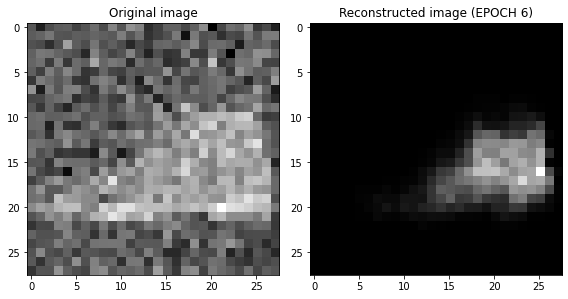

----------- Training --------------
# Epoch 6
----------- Training --------------
EPOCH 6, TRAIN LOSS 0.611757316234264, VAL LOSS 0.6106657460331917
----------- Training --------------
# Epoch 7
----------- Training --------------
EPOCH 7, TRAIN LOSS 0.6100492502780671, VAL LOSS 0.6088436752557754
----------- Training --------------
# Epoch 8
----------- Training --------------
EPOCH 8, TRAIN LOSS 0.6089093319913175, VAL LOSS 0.6078389078378678
----------- Training --------------
# Epoch 9
----------- Training --------------
EPOCH 9, TRAIN LOSS 0.6077265929668507, VAL LOSS 0.6067617699503899
----------- Training --------------
# Epoch 10
----------- Training --------------
EPOCH 10, TRAIN LOSS 0.6066994185143328, VAL LOSS 0.6057687342166901
reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


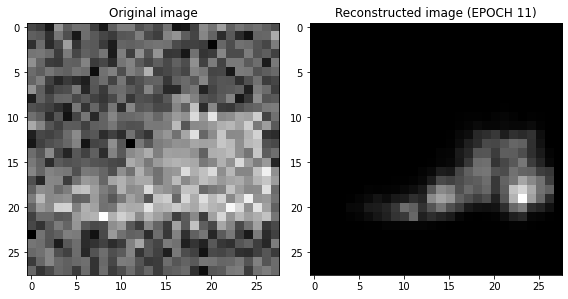

----------- Training --------------
# Epoch 11
----------- Training --------------
EPOCH 11, TRAIN LOSS 0.6056400748009377, VAL LOSS 0.6050159350037575
----------- Training --------------
# Epoch 12
----------- Training --------------
EPOCH 12, TRAIN LOSS 0.6047869372875132, VAL LOSS 0.6040795519948006
----------- Training --------------
# Epoch 13
----------- Training --------------
EPOCH 13, TRAIN LOSS 0.6040407819950834, VAL LOSS 0.6033473908901215
----------- Training --------------
# Epoch 14
----------- Training --------------
EPOCH 14, TRAIN LOSS 0.6032129683393113, VAL LOSS 0.6028153836727143
----------- Training --------------
# Epoch 15
----------- Training --------------
EPOCH 15, TRAIN LOSS 0.6027119989090778, VAL LOSS 0.602588826417923
reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


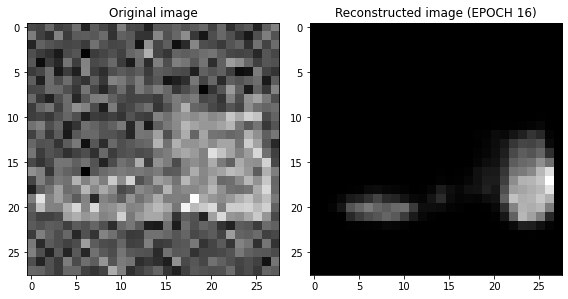

----------- Training --------------
# Epoch 16
----------- Training --------------
EPOCH 16, TRAIN LOSS 0.6022530294479208, VAL LOSS 0.6018122121691704
----------- Training --------------
# Epoch 17
----------- Training --------------
EPOCH 17, TRAIN LOSS 0.601921482289091, VAL LOSS 0.6014462396502495
----------- Training --------------
# Epoch 18
----------- Training --------------
EPOCH 18, TRAIN LOSS 0.6015634440361185, VAL LOSS 0.6012695074081421
----------- Training --------------
# Epoch 19
----------- Training --------------
EPOCH 19, TRAIN LOSS 0.6012582758639721, VAL LOSS 0.6009208038449287
----------- Training --------------
# Epoch 20
----------- Training --------------
EPOCH 20, TRAIN LOSS 0.6010230817693345, VAL LOSS 0.6011526912450791
reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


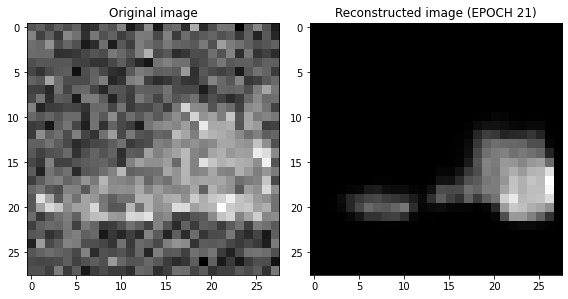

----------- Training --------------
# Epoch 21
----------- Training --------------
EPOCH 21, TRAIN LOSS 0.600775943918431, VAL LOSS 0.6007628351449966
----------- Training --------------
# Epoch 22
----------- Training --------------
EPOCH 22, TRAIN LOSS 0.6005430576649118, VAL LOSS 0.6001536399126053
----------- Training --------------
# Epoch 23
----------- Training --------------
EPOCH 23, TRAIN LOSS 0.6003658320041413, VAL LOSS 0.6000872388482094
----------- Training --------------
# Epoch 24
----------- Training --------------
EPOCH 24, TRAIN LOSS 0.6002155367364275, VAL LOSS 0.5997760474681855
----------- Training --------------
# Epoch 25
----------- Training --------------
EPOCH 25, TRAIN LOSS 0.5998838249673235, VAL LOSS 0.5994814917445183
reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


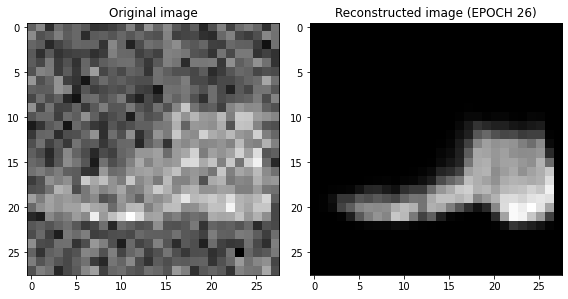

----------- Training --------------
# Epoch 26
----------- Training --------------
EPOCH 26, TRAIN LOSS 0.5996210537058242, VAL LOSS 0.5993871927261353
----------- Training --------------
# Epoch 27
----------- Training --------------
EPOCH 27, TRAIN LOSS 0.5994047010198552, VAL LOSS 0.5989883363246917
----------- Training --------------
# Epoch 28
----------- Training --------------
EPOCH 28, TRAIN LOSS 0.5991591260788288, VAL LOSS 0.5990637004375458
----------- Training --------------
# Epoch 29
----------- Training --------------
EPOCH 29, TRAIN LOSS 0.5989597815148374, VAL LOSS 0.5986902415752411


In [ ]:
epochs = 30

convh = parameters['convh']
linh = parameters['linh']
lr = parameters['lr']
encoded_space_dim = parameters['encoded_space_dim']


encoder = Encoder(encoded_space_dim , convh , linh)
decoder = Decoder(encoded_space_dim , convh , linh)



encoder.to(device)
decoder.to(device)
params_to_optimize = [
  {'params': encoder.parameters()},
  {'params': decoder.parameters()}
]
model={"encoder":encoder,"decoder":decoder}
optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-4)
loss_fn=nn.MSELoss()
eng=denoise_engine(model,optimizer,loss_fn,device)
train_loss_log = []
val_loss_log = []

best_loss=np.inf
save_model=True
early_stopping = 5
early_stopping_counter=0
for epoch_num in range(epochs):
  print('----------- Training --------------')
  print(f'# Epoch {epoch_num}')
  print('----------- Training --------------')
  train_loss=eng.train(train_dataloader)
  train_loss_log.append(train_loss)
  val_loss=eng.evaluate(test_dataloader)
  val_loss_log.append(val_loss)
  print(f"EPOCH {epoch_num}, TRAIN LOSS {train_loss}, VAL LOSS {val_loss}")
  if val_loss < best_loss :
      best_loss=val_loss
      early_stopping_counter=0

  else :
      early_stopping_counter+=1
  if early_stopping_counter>early_stopping:
      break
  if (epoch_num%5) == 0:
    img = test_dataset[0][0]['noise'].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    print("reconstructed shape ",rec_img.shape)
    print("Orignal Image shape ",img.shape)
    fig, axs = plt.subplots(1, 2, figsize=(8,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    plt.show()
    plt.close()


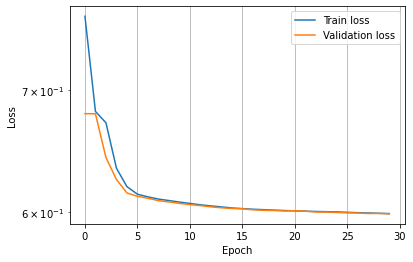

In [ ]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


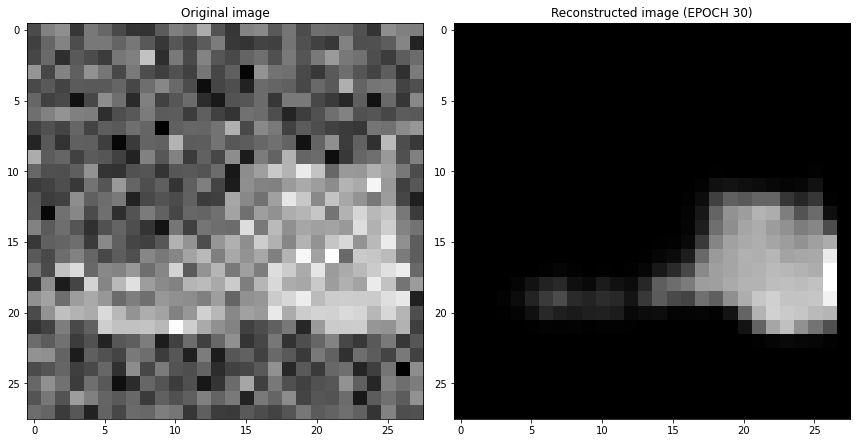

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


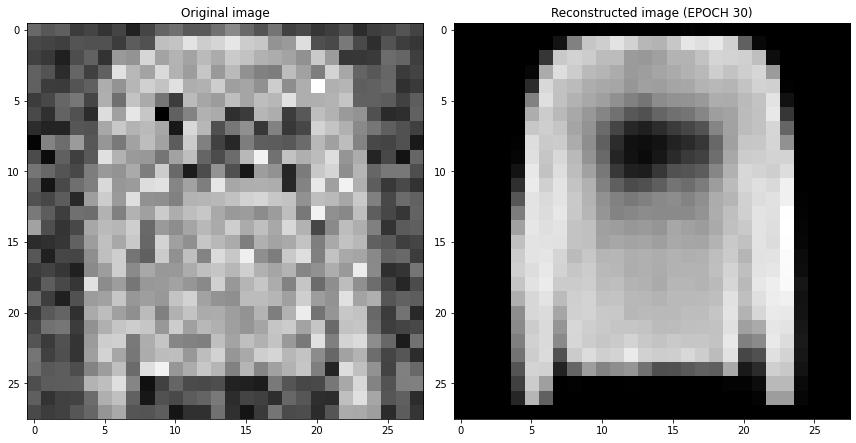

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


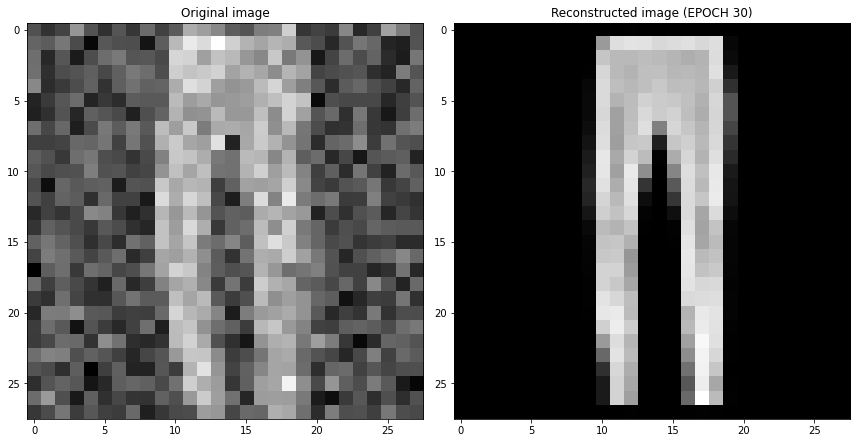

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


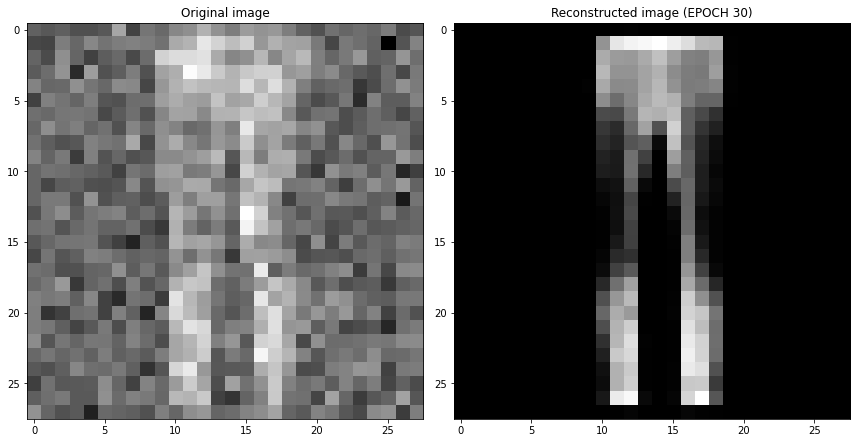

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


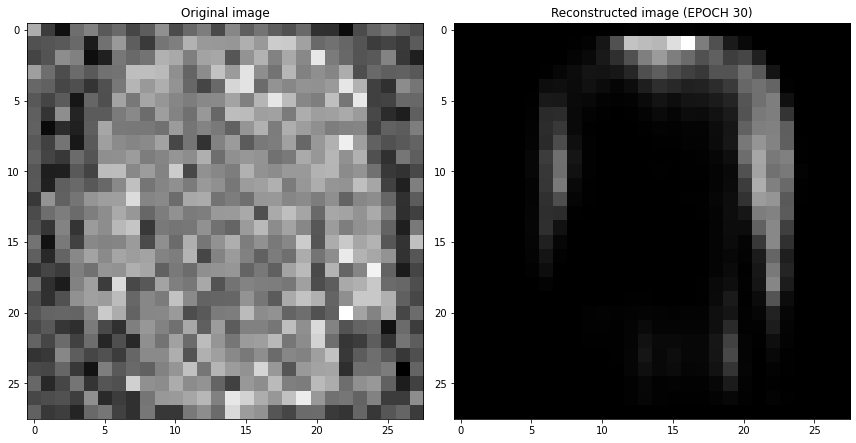

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


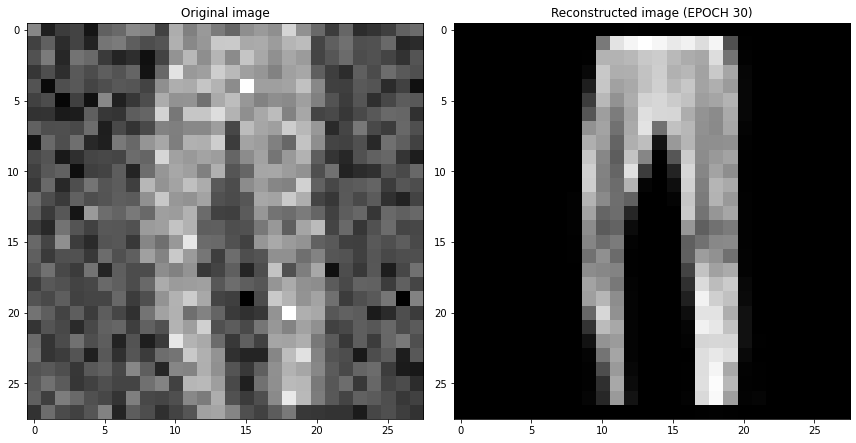

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


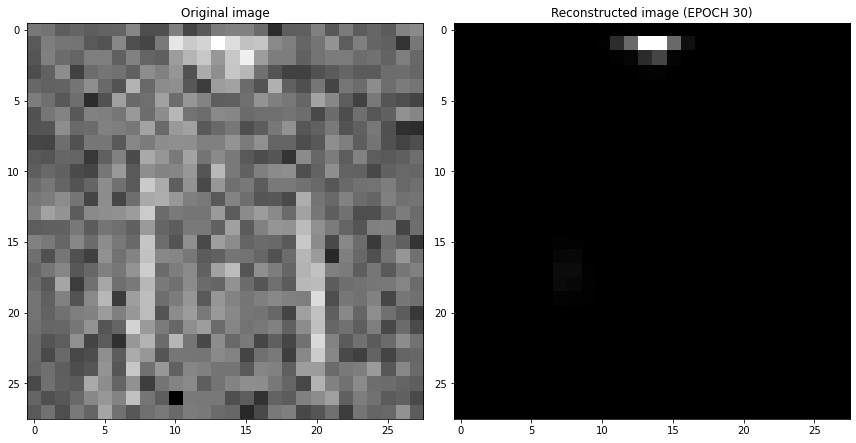

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


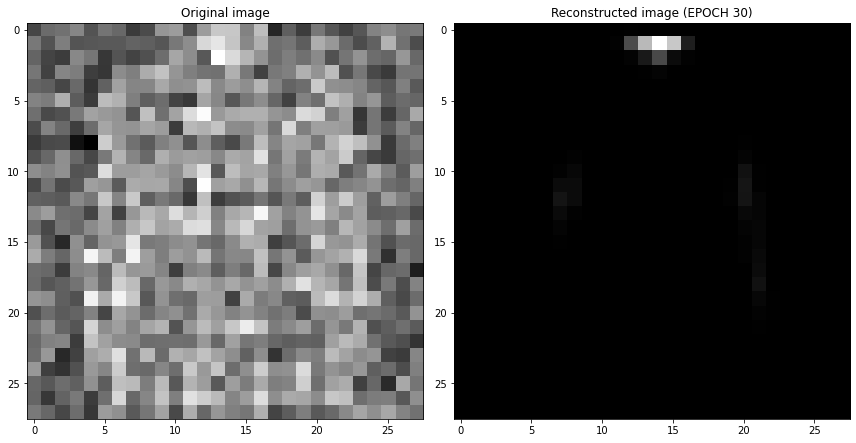

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


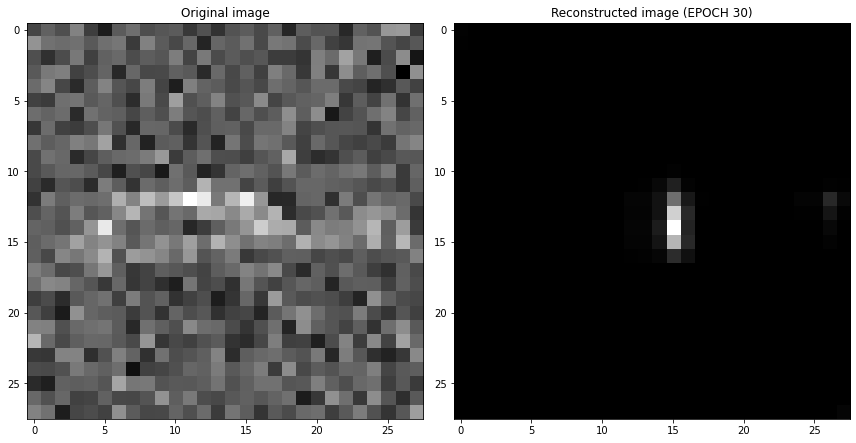

reconstructed shape  torch.Size([1, 1, 28, 28])
Orignal Image shape  torch.Size([1, 1, 28, 28])


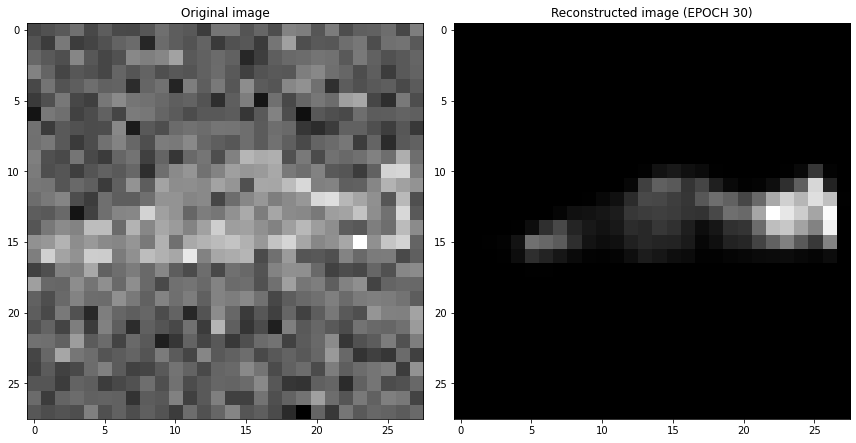

In [ ]:
for i in range (10):
  img = test_dataset[i][0]['noise'].unsqueeze(0).to(device)
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      rec_img  = decoder(encoder(img))
  # Plot the reconstructed image
  print("reconstructed shape ",rec_img.shape)
  print("Orignal Image shape ",img.shape)
  fig, axs = plt.subplots(1, 2, figsize=(12,6))
  axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0].set_title('Original image')
  axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
  plt.tight_layout()
  plt.pause(0.1)